# Setup

In [1]:
# Import packages
import os
import re
import sys
import json
import string
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

tf.__version__ # 2.x

'2.3.0'

In [2]:
# # Globals
# BUFFER_SIZE = 5000
# BUFFER_BATCH_SIZE = 64
# VOCAB_SIZE = 5000
# MAX_SEQUENCE_LENGTH = 512
# EMBEDDING_DIM = 128

# Setup input pipeline

In [3]:
dataset, info = tfds.load(name = "imdb_reviews", with_info=True, as_supervised=True)

train_dataset, test_dataset = dataset["train"], dataset["test"]
print(train_dataset.element_spec, test_dataset.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)) (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [4]:
for review, label in train_dataset.take(1):
    print("Review;", review)
    print("Label:", label)

Review; tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
Label: tf.Tensor(0, shape=(), dtype=int64)


In [5]:
for review, label in test_dataset.take(1):
    print("Review;", review)
    print("Label:", label)

Review; tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
Label: tf.Tens

# Data prepocessing

In [6]:
# Create optimized input pipeline
train_dataset = train_dataset.shuffle(5000).batch(64).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(5000).batch(64).prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
# Having looked at our data above, we see that the raw text contains HTML break
# tags of the form '<br />'. These tags will not be removed by the default
# standardizer (which doesn't strip HTML).
# We will need to create a custom standardization function.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )

# Create a tex vecotrizer
encoder = TextVectorization(
    max_tokens = 1000,
    standardize = custom_standardization,
    split = "whitespace",
    output_mode = "int",
    output_sequence_length = 256
)

# Adapt to train text
encoder.adapt(train_dataset.map(lambda text, label: text))

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return encoder(text), label

# Vectorize the data
train_dataset = train_dataset.map(vectorize_text)
test_dataset = test_dataset.map(vectorize_text)

In [8]:
for review, label in train_dataset.take(1):
    print("Review;", review)
    print("Label:", label)

Review; tf.Tensor(
[[209  11 408 ...   1 285   4]
 [ 10   1 209 ...   1   1   1]
 [  1   6   1 ...   0   0   0]
 ...
 [ 11   7   4 ...   0   0   0]
 [  1 218  42 ...   0   0   0]
 [ 35   2 624 ...   0   0   0]], shape=(64, 256), dtype=int64)
Label: tf.Tensor(
[0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1
 1 1 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0], shape=(64,), dtype=int64)


In [9]:
for review, label in test_dataset.take(1):
    print("Review;", review)
    print("Label:", label)

Review; tf.Tensor(
[[  8 115   3 ...   0   0   0]
 [ 29 292  12 ...  19 143 178]
 [  8   1   5 ...   1   1   1]
 ...
 [ 38   1   5 ...  39 108   1]
 [104 147 100 ... 737  14  72]
 [142   1  12 ...   0   0   0]], shape=(64, 256), dtype=int64)
Label: tf.Tensor(
[1 1 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 0
 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0], shape=(64,), dtype=int64)


# Modelling

In [10]:
from conv_classifier import ConvClassifier

In [11]:
# Instatiate model
model = ConvClassifier(vocab_size=1000, embedding_dim=100)

# Compile
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train and validation
history = model.fit(
    train_dataset,
    epochs = 50,
    validation_data = test_dataset,
    validation_steps = 10,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]
)

Epoch 1/50
391/391 [==============================] - 4s 10ms/step - loss: 0.4946 - accuracy: 0.7370 - val_loss: 0.3364 - val_accuracy: 0.8594
Epoch 2/50
391/391 [==============================] - 4s 10ms/step - loss: 0.3518 - accuracy: 0.8474 - val_loss: 0.3309 - val_accuracy: 0.8531
Epoch 3/50
391/391 [==============================] - 4s 10ms/step - loss: 0.3069 - accuracy: 0.8708 - val_loss: 0.3144 - val_accuracy: 0.8656
Epoch 4/50
391/391 [==============================] - 4s 10ms/step - loss: 0.2711 - accuracy: 0.8878 - val_loss: 0.3609 - val_accuracy: 0.8609
Epoch 5/50
391/391 [==============================] - 4s 10ms/step - loss: 0.2285 - accuracy: 0.9070 - val_loss: 0.3426 - val_accuracy: 0.8500
Epoch 6/50
391/391 [==============================] - 4s 10ms/step - loss: 0.1930 - accuracy: 0.9232 - val_loss: 0.4827 - val_accuracy: 0.8297
Epoch 7/50
391/391 [==============================] - 4s 10ms/step - loss: 0.1666 - accuracy: 0.9342 - val_loss: 0.3988 - val_accuracy: 0.8484

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


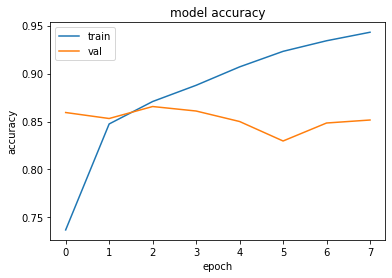

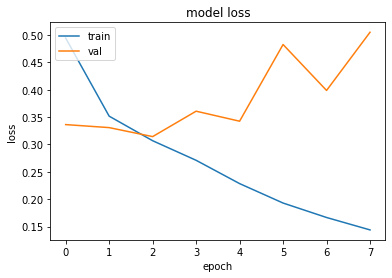

In [12]:
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

# Summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [13]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test loss;", test_loss)
print("Test accuracy:", test_acc)

391/391 [==============================] - 2s 6ms/step - loss: 0.4996 - accuracy: 0.8388
Test loss; 0.49957171082496643
Test accuracy: 0.8388400077819824
